**Preparing your colab pc by useing your username and key from kaggle**

In [ ]:
import os
os.environ["KAGGLE_USERNAME"] = "abdelrahmanabdelhakm"
os.environ["KAGGLE_KEY"] = "b9ed1f21acade2853963b94f91272ff8"

**this is the tool used from kaggle to able you downloading your data**

In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:19<00:00, 60.7MB/s]
100% 2.29G/2.29G [00:19<00:00, 126MB/s] 


In [ ]:
! ls

chest-xray-pneumonia.zip  sample_data


In [ ]:
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
BASE_PATH = os.path.join("chest_xray", "chest_xray")
TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH = os.path.join(BASE_PATH, "test")
VAL_PATH = os.path.join(BASE_PATH, "val")

## Data Preprocessing


1.   convert all images to gray scale
2.   resize all images to 100X100
3.   format the images in x_data, y_data for the training, testing and validation



In [ ]:
! ls 'chest_xray/chest_xray/train'

NORMAL	PNEUMONIA


In [ ]:
import cv2
import numpy as np
target_labels = ['NORMAL', 'PNEUMONIA']
target_size = 100
# stored_location ---> "c:\user\abdelrahman\dataset"
def load_images (stored_location):
  x_images = []
  y_labels = []
  info = {}
  for folder_name in target_labels:
    index = target_labels.index(folder_name)
    folder_path = os.path.join(stored_location, folder_name)
    info[folder_name] = 0
    for image_name in os.listdir(folder_path):
      image_path = os.path.join(folder_path, image_name)
      image_extension = image_path.split(".")[-1]
      if image_extension in ["jpeg", "png", "jpg"]:
        gray_image = cv2.imread(image_path, 0)
        resized_image = cv2.resize(gray_image, (target_size, target_size))
        scaled_image = resized_image.astype("float32") / 255.0
        x_images.append(scaled_image)
        y_labels.append(index)
        info[folder_name] += 1
  x_data_array = np.array(x_images, dtype='float32')
  y_data_array = np.array(y_labels, dtype='uint8')
  return x_data_array, y_data_array, info

In [ ]:
x_val, y_val, val_info = load_images(VAL_PATH)
val_info

{'NORMAL': 8, 'PNEUMONIA': 8}

In [ ]:
x_train, y_train, train_info = load_images(TRAIN_PATH)
train_info

{'NORMAL': 1341, 'PNEUMONIA': 3875}

In [ ]:
x_test, y_test, test_info = load_images(TEST_PATH)
test_info

{'NORMAL': 234, 'PNEUMONIA': 390}

**Visualize sample of the data**

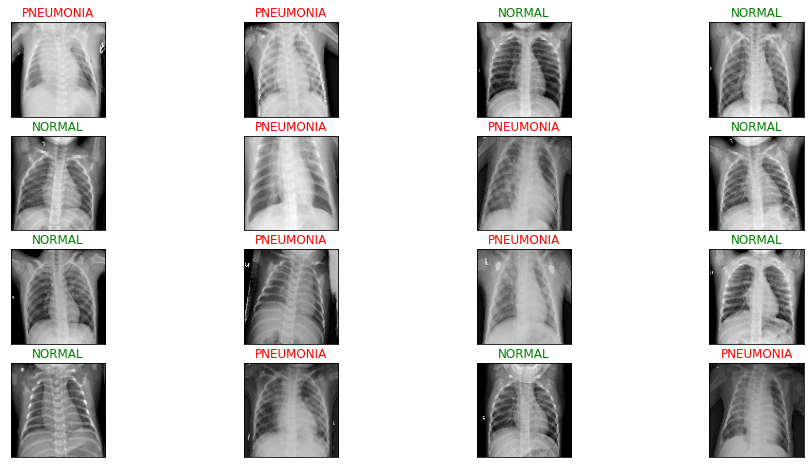

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (16, 8))
random_indexes = np.random.choice(x_train.shape[0], 16)
for i in range(16):
  r_index = random_indexes[i]
  image = x_train[r_index]
  ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
  ax.imshow(image, cmap="gray")
  if y_train[r_index] == 0:
    label = "NORMAL"
    color = "green"
  else:
    label = "PNEUMONIA"
    color = "red"
  ax.set_title(label, c= color)

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
sample = x_train[0].reshape(1, target_size, target_size, 1)
sample.shape

(1, 100, 100, 1)

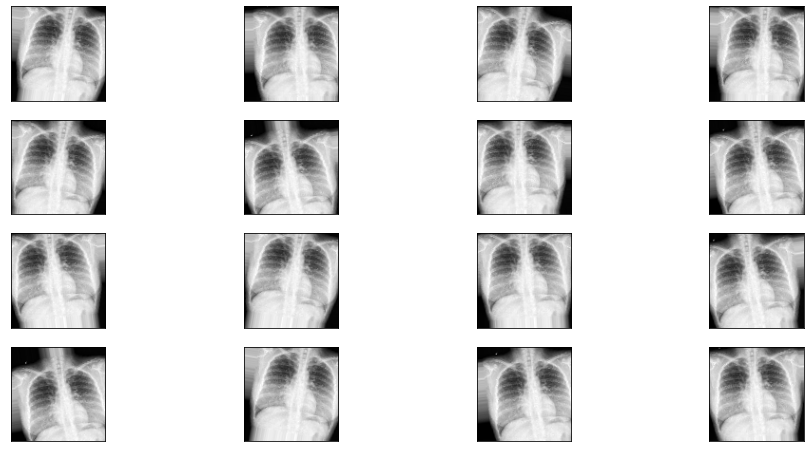

In [ ]:
gen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 10
)
j=0
fig = plt.figure(figsize=(16,8))
for gen_image in gen.flow(sample, batch_size=1):
  agu_image = gen_image.reshape(target_size, target_size)
  ax = fig.add_subplot(4,4, j+1, xticks=[], yticks=[])
  ax.imshow(agu_image, cmap="gray")
  j+=1
  if j == 16:
    break

**Applying some edits on our data and generate more images contain the same information of original images to improve model processing**

In [ ]:
train_data_gen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 10,
    zoom_range = 0.2
)
test_data_gen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 10,
    zoom_range = 0.2
)
val_data_gen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 10,
    zoom_range = 0.2
)

**Reshaping our data to can enter it in ImageDataGenerator**

In [ ]:
x_train = x_train.reshape(*x_train.shape, 1)
x_test = x_test.reshape(*x_test.shape, 1)
x_val = x_val.reshape(*x_val.shape, 1)
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of x_val:", x_val.shape)

Shape of x_train: (5216, 100, 100, 1)
Shape of x_test: (624, 100, 100, 1)
Shape of x_val: (16, 100, 100, 1)


**Create folder to save generated images in it**

In [ ]:
if not os.path.isdir("agu_images"):
  os.mkdir("agu_images")

In [ ]:
train_batches = train_data_gen.flow(x_train, y_train, batch_size=32, save_prefix="train", save_to_dir="agu_images", save_format="png" )
test_batches = test_data_gen.flow(x_test, y_test, batch_size=32, save_prefix="test", save_to_dir="agu_images", save_format="png" )
val_batches = val_data_gen.flow(x_val, y_val, batch_size=32, save_prefix="val", save_to_dir="agu_images", save_format="png" )

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight("balanced", np.unique(y_train), y_train)
class_weight

array([1.9448173 , 0.67303226])

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# i will basiclly use approach like vgg16
chx_model = Sequential()
chx_model.add(Conv2D(filters=16, kernel_size=3, padding="same", activation="relu", input_shape=(100,100,1)))
chx_model.add(BatchNormalization())
chx_model.add(MaxPooling2D(pool_size=2))
chx_model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
chx_model.add(MaxPooling2D(pool_size=2))
chx_model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))

chx_model.add(BatchNormalization())
chx_model.add(MaxPooling2D(pool_size=2))
chx_model.add(Dropout(0.3)) #Minimize over fitting
chx_model.add(Flatten())
#ANN layer
chx_model.add(Dense(500, activation='relu'))
chx_model.add(Dropout(0.4))
chx_model.add(Dense(1, activation='sigmoid')) #The output is a Binary classification problem

chx_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)       

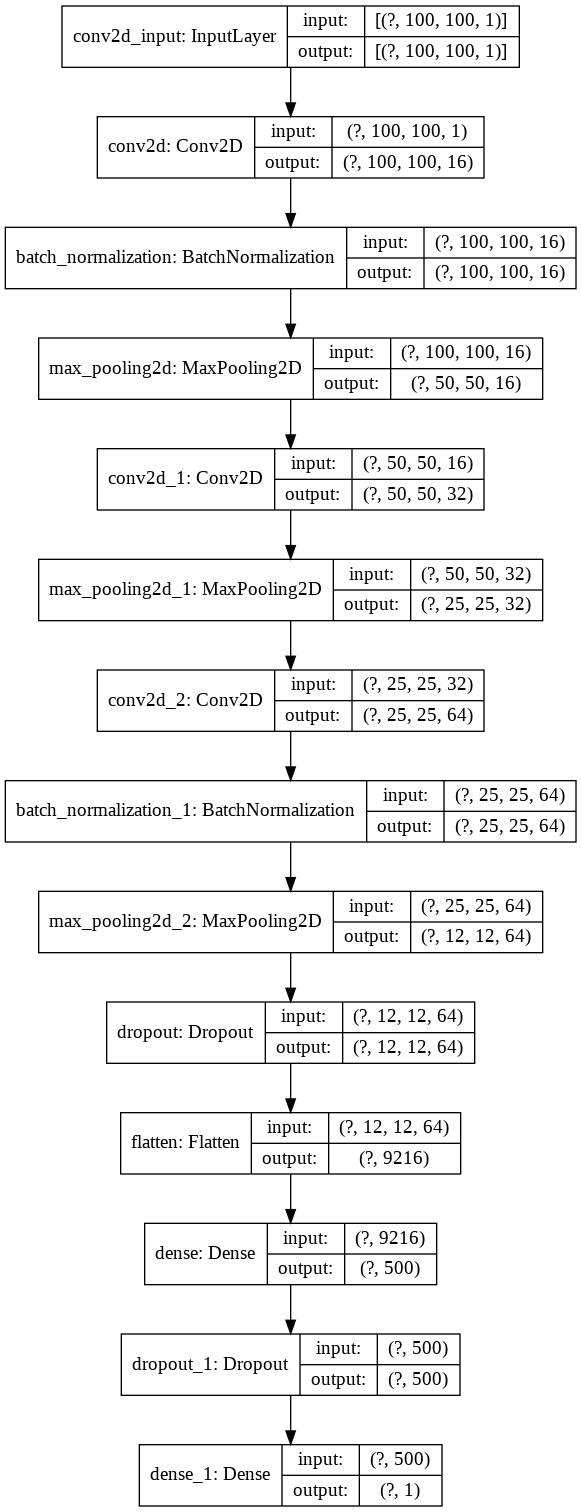

In [ ]:
from keras.utils import plot_model
plot_model(chx_model, show_shapes=True, show_layer_names=True, to_file="chest_model.png")

In [ ]:
chx_model.compile(loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor="val_loss", patience=10) #if accuracy not improved until 10 epoch --> stop training !!
mc = ModelCheckpoint(filepath="best_model.hdf5", monitor="val_loss", save_best_only=True)
#mc: -->1.5-->1(save)-->0.85(save)-->0.9(not save)-->0.86(not save)-->0.75(save)...and so on
callback_funcs=[es, mc]

history= chx_model.fit_generator(
    generator = train_batches,
    validation_data = val_batches,
    epochs = 10,
    callbacks = callback_funcs,
    class_weight = {0: 1.9448173, 1: 0.67303226},
    steps_per_epoch = len(x_train)//32
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
163/163 [==============================] - 70s 432ms/step - loss: 1.0139 - accuracy: 0.8156 - val_loss: 4.7545 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 70s 427ms/step - loss: 0.4060 - accuracy: 0.8691 - val_loss: 9.2006 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 69s 425ms/step - loss: 0.3256 - accuracy: 0.8913 - val_loss: 8.4090 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 69s 426ms/step - loss: 0.2873 - accuracy: 0.8921 - val_loss: 1.8001 - val_accuracy: 0.6875
Epoch 5/10
163/163 [==============================] - 69s 425ms/step - loss: 0.2730 - accuracy: 0.9055 - val_loss: 2.9745 - val_accuracy: 0.5625
Epoch 6/10
163/163 [==============================] - 69s 424ms/step - loss: 0.2350 - accuracy: 0.9172 - val_loss: 0.9739 - val_accuracy: 0.6875
Epoch 7/10
163/163 [==============================] - 